***Part 1: Develop a CNN-based model to classify QuickDraw images ***

In [0]:
from __future__ import print_function

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import functools, itertools, json, os, re, textwrap
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

# Get the data

In [2]:
# Retrieve list of classes.

def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print('available: (%d)' % len(all_ndjsons))
print('\n'.join(textwrap.wrap(
    ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
    width=100)))

available: (309)
The Eiffel Tower The Great Wall of China The Mona Lisa aircraft carrier airplane alarm clock
ambulance angel animal migration ant anvil apple arm asparagus axe backpack banana bandage barn
baseball bat baseball basket basketball bat bathtub beach bear beard bed bee belt bench bicycle
binoculars bird birthday cake blackberry blueberry book boomerang bottlecap bowtie bracelet brain
bread bridge broccoli broom bucket bulldozer bus bush butterfly cactus cake calculator calendar
camel camera camouflage campfire candle cannon canoe car carrot castle cat ceiling fan cell phone
cello chair chandelier church circle clarinet clock cloud coffee cup compass computer cookie cooler
couch cow crab crayon crocodile crown cruise ship cup diamond dishwasher diving board dog dolphin
donut door dragon dresser drill drums duck dumbbell ear elbow elephant envelope eraser eye
eyeglasses face fan feather fence finger fire hydrant fireplace firetruck fish flamingo flashlight
flip flops floor l

In [0]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
  os.mkdir(data_path)

# Mini group of two animals.
pets = ['cat', 'dog']

# Somewhat larger group of zoo animals.
zoo = ['elephant', 'giraffe', 'kangaroo', 'lion', 'monkey', 'panda',
       'penguin', 'rhinoceros', 'tiger', 'zebra']

# Even larger group of all animals.
animals = ['bat', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl',
           'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon',
           'rhinoceros', 'scorpion', 'sea turtle', 'shark', 'sheep',
           'snail', 'spider', 'squirrel', 'teddy-bear', 'tiger',
           'whale', 'zebra']

# Create your own group -- the more classes you include the more challenging
# the classification task will be...

# Choose one of the above groups.
# Note: This will result in ~100MB of download per class.
classes, classes_name = zoo, 'zoo'

In [4]:
# Download the chosen group.

def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print('\n%d classes:' % len(classes))

for name in classes:
    print(name, end=' ')
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')



10 classes:
elephant 70.86 MB
giraffe 58.27 MB
kangaroo 96.06 MB
lion 90.47 MB
monkey 91.05 MB
panda 97.04 MB
penguin 137.90 MB
rhinoceros 92.20 MB
tiger 86.09 MB
zebra 92.10 MB

DONE :)


# Inspect the data

In [5]:
# So let's check out the downloaded files...
!ls -lh $data_path

total 913M
-rw-r--r-- 1 root root  71M Nov 17 20:29 elephant.ndjson
-rw-r--r-- 1 root root  59M Nov 17 20:29 giraffe.ndjson
-rw-r--r-- 1 root root  97M Nov 17 20:29 kangaroo.ndjson
-rw-r--r-- 1 root root  91M Nov 17 20:29 lion.ndjson
-rw-r--r-- 1 root root  92M Nov 17 20:29 monkey.ndjson
-rw-r--r-- 1 root root  98M Nov 17 20:29 panda.ndjson
-rw-r--r-- 1 root root 138M Nov 17 20:29 penguin.ndjson
-rw-r--r-- 1 root root  93M Nov 17 20:30 rhinoceros.ndjson
-rw-r--r-- 1 root root  87M Nov 17 20:30 tiger.ndjson
-rw-r--r-- 1 root root  93M Nov 17 20:30 zebra.ndjson


In [6]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[1]
print(open(path).read()[:1000] + '...')

{"word":"giraffe","countrycode":"BR","timestamp":"2017-01-26 17:23:19.3785 UTC","recognized":true,"key_id":"5807561943023616","drawing":[[[25,9,0,1,13,35],[32,46,59,65,67,47]],[[64,47,36,25,25,41,53,66,69],[14,15,21,37,42,56,59,41,24]],[[20,39],[8,23]],[[51,52],[0,11]],[[56,46,46,55],[55,91,127,183]],[[74,70,73],[58,95,172]],[[53,79,100,126,149,150,138,131,96,47,39,40],[187,178,174,173,178,190,203,207,215,203,190,182]],[[54,36,22],[204,228,253]],[[73,49],[220,255]],[[118,119,132],[205,223,252]],[[142,143,159],[195,206,238]],[[143,161,165,169,166],[181,168,169,200,214]]]}
{"word":"giraffe","countrycode":"FR","timestamp":"2017-01-29 13:59:05.33086 UTC","recognized":true,"key_id":"5747753718120448","drawing":[[[34,35,45,59,65,67,69,74,79,81,79,81,88,96,99,99,103,101,104,121,129,127,137,151,158,166,163,155,177,198,191,161,115,82,65,56,53,56],[101,249,246,231,218,184,179,179,181,186,220,244,245,230,215,183,199,225,249,255,251,187,203,242,246,225,207,186,148,132,129,133,117,98,85,71,54,20]],

In [7]:
# Parse single line.
data_json = json.loads(open(path).readline())
data_json.keys()

[u'word', u'countrycode', u'timestamp', u'recognized', u'key_id', u'drawing']

In [8]:
# So we have some meta information...
for k, v in data_json.items():
    if k != 'drawing':
        print('%20s   ->   %s' % (k, v))

                word   ->   giraffe
         countrycode   ->   BR
           timestamp   ->   2017-01-26 17:23:19.3785 UTC
          recognized   ->   True
              key_id   ->   5807561943023616


In [9]:
# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
[np.array(stroke).shape for stroke in drawing]

[(2, 6),
 (2, 9),
 (2, 2),
 (2, 2),
 (2, 4),
 (2, 3),
 (2, 12),
 (2, 3),
 (2, 2),
 (2, 3),
 (2, 3),
 (2, 5)]

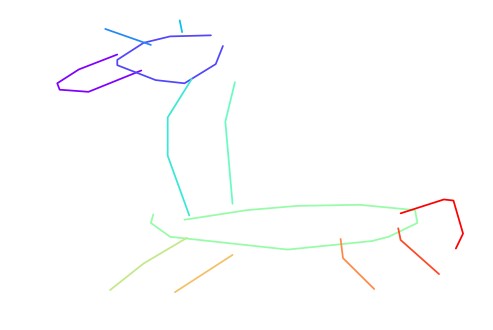

In [11]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
  # Use a different color for each stroke
  colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
  plt.axis('off')
  for stroke, c in zip(drawing, colors):
    #print(stroke[0], stroke[1])
    plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
draw_strokes(drawing)

In [12]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

print('loading some "%s"...' % classes[0])
sample = loadn(classes[0], 100)

loading some "elephant"...


In [13]:
sample[0]

{u'countrycode': u'RO',
 u'drawing': [array([[  0,   0,   6,  29,  46,  66,  75,  89, 110, 122, 143, 168, 196,
          210, 233, 242, 255, 255, 248, 220, 212, 211, 198, 195, 191, 190,
          185, 176, 169, 168, 173, 168, 151, 147, 144, 154, 151, 127, 111,
          107, 106,  94,  90,  87,  97,  82,  60],
         [113,  98,  79,  36,  14,   0,   0,   6,  44,  54,  55,  45,  45,
           40,  39,  51,  76, 100, 109, 122, 148, 173, 180, 180, 172, 147,
          128, 128, 142, 154, 176, 181, 181, 179, 172, 128, 124, 120, 127,
          134, 169, 169, 166, 156, 121, 117, 118]])],
 u'key_id': u'4916532524089344',
 u'recognized': True,
 u'timestamp': u'2017-01-31 11:22:07.29568 UTC',
 u'word': u'elephant'}

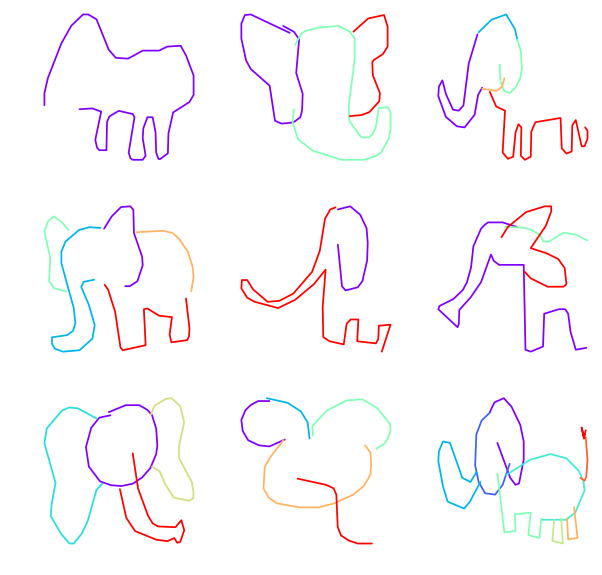

In [14]:
# Some more drawings...
plt.figure(figsize=(10, 10))
n = 3
for x in range(n):
    for y in range(n):
        i = x * n + y
        plt.subplot(n, n, i + 1)
        drawing = sample[i]['drawing']
        draw_strokes(drawing)
        
# Elephants!

In [15]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate >200k examples / class...
for name in classes:
    print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

elephant 126969 recognized 104986
giraffe 127182 recognized 122396
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
monkey 127633 recognized 105650
panda 113613 recognized 94814
penguin 253791 recognized 231826
rhinoceros 188484 recognized 166539
tiger 121067 recognized 110177
zebra 144608 recognized 127159


# Strokes -> Pictures

In [0]:
# The sequence information is important! But... for now we'll 
# convert these sequences to plain old images.

In [0]:
def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img

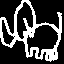

In [18]:
json_to_img(drawing)

monkey


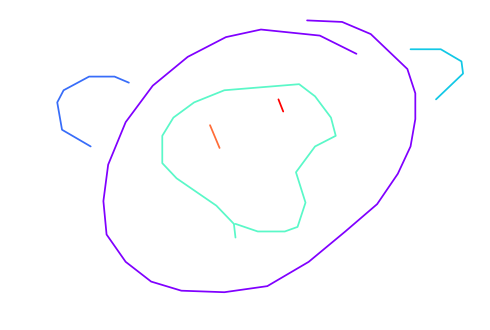

In [19]:
# Fetch some images + shuffle order.
n_per_class = 10000
drawings_matrix = [loadn(name, n_per_class) for name in classes]
drawings_list = functools.reduce(lambda x, y: x + y, drawings_matrix, [])
np.random.seed(1)
drawings_list = np.random.permutation(drawings_list)

# Quick test to see how our code works so far
draw_strokes(drawings_list[0]['drawing'])
print(str(drawings_list[0]['word']))

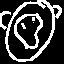

In [20]:
json_to_img(drawings_list[0]['drawing'])

# Save a dataset to disk

In [0]:
X, y = [], []
for drawing in drawings_list:
  X.append(np.array(json_to_img(drawing['drawing'])))
  y.append(str(drawing['word']))
  
dataset_path = 'mini-quickdraw.npz'
out = open(dataset_path, 'w')
np.savez_compressed(out, X, y, X=X, y=y)

In [22]:
# Demonstrate loading
loaded = np.load(open(dataset_path))
X, y = loaded["X"], loaded["y"]
print(X.shape, y.shape)

(100000, 64, 64) (100000,)


monkey


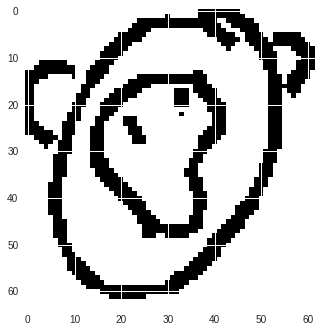

In [23]:
plt.imshow(X[0])
print(y[0])

In [0]:
x = X.reshape((-1, 64, 64, 1))

In [34]:
y

array(['monkey', 'tiger', 'giraffe', ..., 'elephant', 'rhinoceros',
       'zebra'], dtype='|S10')

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
Y= le.transform(y)

In [36]:
Y

array([4, 8, 1, ..., 0, 7, 9])

In [0]:
from keras.utils import to_categorical
y_binary = to_categorical(Y)
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_binary, test_size=.25, random_state=42)

In [0]:
X_train = np.divide(X_train, 255)
X_test = np.divide(X_test, 255)


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten

In [32]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs = 3,
    verbose = 1
)



Epoch 1/3
75000/75000 [==============================] - 49s 654us/step - loss: 0.6395 - acc: 0.7793
Epoch 2/3
75000/75000 [==============================] - 49s 650us/step - loss: 0.3746 - acc: 0.8698
Epoch 3/3
75000/75000 [==============================] - 49s 651us/step - loss: 0.2568 - acc: 0.9079


In [42]:
score = model.evaluate(X_test, Y_test, batch_size=32)

25000/25000 [==============================] - 5s 201us/step


In [43]:
score

[0.39234922538280487, 0.87132]

In [44]:
print('Test loss', score[0])
print('Test Accuracy', score[1])

Test loss 0.39234922538280487
Test Accuracy 0.87132


**Part2: Design and implement an AutoML-style image classifier and demonstrate it on the
flowers dataset ** 

In [45]:
cd ~

/root


In [46]:
!curl -O http://download.tensorflow.org/example_images/flower_photos.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  74.1M      0  0:00:02  0:00:02 --:--:-- 74.1M


In [0]:
!tar xzf flower_photos.tgz

In [48]:
ls

data/           flower_photos.tgz  Flowers.zip  root/
flower_photos/  Flowers/           __MACOSX/


In [49]:
import keras
keras.__version__

'2.2.4'

In [0]:
import os
train_dir = "/root/flower_photos"

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [52]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [65]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [0]:
conv_base.trainable = False

In [67]:

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [69]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 3670 images belonging to 5 classes.
Found 3670 images belonging to 5 classes.
Epoch 1/10
 - 28s - loss: 1.4401 - acc: 0.4405 - val_loss: 1.2667 - val_acc: 0.5330
Epoch 2/10
 - 25s - loss: 1.1500 - acc: 0.5945 - val_loss: 0.9863 - val_acc: 0.6910
Epoch 3/10
 - 25s - loss: 0.9908 - acc: 0.6525 - val_loss: 0.8982 - val_acc: 0.6970
Epoch 4/10
 - 25s - loss: 0.9137 - acc: 0.6740 - val_loss: 0.7890 - val_acc: 0.7444
Epoch 5/10
 - 25s - loss: 0.8217 - acc: 0.7265 - val_loss: 0.7196 - val_acc: 0.7630
Epoch 6/10
 - 25s - loss: 0.7890 - acc: 0.7260 - val_loss: 0.7225 - val_acc: 0.7560
Epoch 7/10
 - 25s - loss: 0.7577 - acc: 0.7335 - val_loss: 0.6935 - val_acc: 0.7700
Epoch 8/10
 - 25s - loss: 0.7254 - acc: 0.7485 - val_loss: 0.7033 - val_acc: 0.7697
Epoch 9/10
 - 25s - loss: 0.7334 - acc: 0.7500 - val_loss: 0.6503 - val_acc: 0.7960
Epoch 10/10
 - 25s - loss: 0.7005 - acc: 0.7575 - val_loss: 0.6328 - val_acc: 0.7840


In [0]:
rm Flowers.zip

In [71]:
from six.moves import urllib
source = "https://storage.googleapis.com/mydeep-bucket/Flowers.zip"
dest = "Flowers.zip"
urllib.request.urlretrieve(source, dest)

('Flowers.zip', <httplib.HTTPMessage instance at 0x7f593c839248>)

In [72]:
ls

data/           flower_photos.tgz  Flowers.zip  root/
flower_photos/  Flowers/           __MACOSX/


In [73]:
pwd

u'/root'

In [0]:
from zipfile import ZipFile

In [0]:
zip=ZipFile('Flowers.zip')
from zipfile import ZipFile
zf = ZipFile(r'/root/Flowers.zip', 'r')
zf.extractall()
zf.close()

In [76]:
ls

data/           flower_photos.tgz  Flowers.zip  root/
flower_photos/  Flowers/           __MACOSX/


In [0]:
test_dir='/root/Flowers'

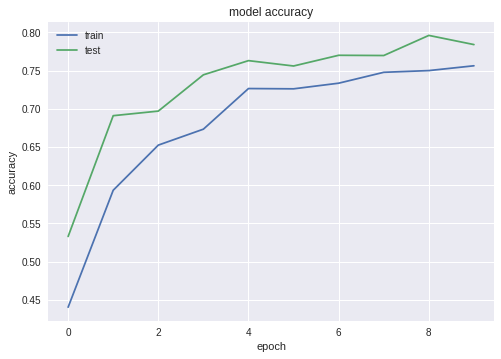

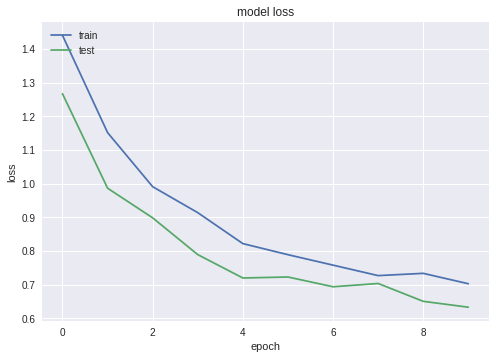

In [78]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=1)
print('test acc:', test_acc)

Found 10 images belonging to 5 classes.
test acc: 1.0


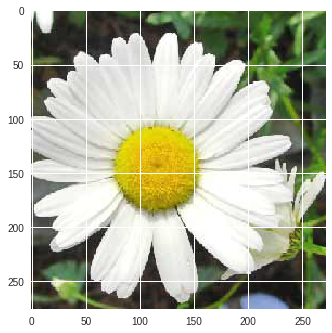

In [84]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
img = Image.open('Flowers/daisy/daisy1.jpg')
img = np.array(img)
plt.imshow(img)